In [1]:
from IPython.display import Image

## Seq2Seq 모델을 활용한 챗봇 생성

### Seq2Seq 모델의 개요

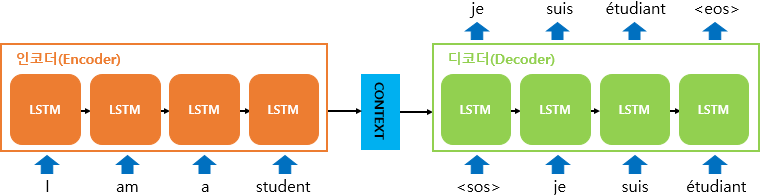

In [2]:
Image('https://wikidocs.net/images/page/24996/%EC%9D%B8%EC%BD%94%EB%8D%94%EB%94%94%EC%BD%94%EB%8D%94%EB%AA%A8%EB%8D%B8.PNG')

## 데이터셋에 필요한 라이브러리를 다운로드 받습니다.

`Korpora`는 한글 자연어처리 데이터)셋입니다.

- [깃헙 주소 링크](https://github.com/ko-nlp/Korpora)
- [공식 도큐먼트](https://pypi.org/project/Korpora/)

설치 명령어

In [3]:
# !pip install Korpora

- 이 중 챗봇용 데이터셋인 `KoreanChatbotKorpus`를 다운로드 받습니다.
- `KoreanChatbotKorpus` 데이터셋을 활용하여 챗봇 모델을 학습합니다.
- text, pair로 구성되어 있습니다.
- 질의는 **text**, 답변은 **pair**입니다.

In [4]:
from Korpora import KoreanChatbotKorpus
corpus = KoreanChatbotKorpus()


    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : songys@github
    Repository : https://github.com/songys/Chatbot_data
    References :

    Chatbot_data_for_Korean v1.0
      1. 챗봇 트레이닝용 문답 페어 11,876개
      2. 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링
    자세한 내용은 위의 repository를 참고하세요.

    # License
    CC0 1.0 Universal (CC0 1.0) Public Domain Dedication
    Details in https://creativecommons.org/publicdomain/zero/1.0/



예시 텍스트를 보면 구어체로 구성되어 있습니다.

In [5]:
corpus.get_all_texts()[:10]

['12시 땡!',
 '1지망 학교 떨어졌어',
 '3박4일 놀러가고 싶다',
 '3박4일 정도 놀러가고 싶다',
 'PPL 심하네',
 'SD카드 망가졌어',
 'SD카드 안돼',
 'SNS 맞팔 왜 안하지ㅠㅠ',
 'SNS 시간낭비인 거 아는데 매일 하는 중',
 'SNS 시간낭비인데 자꾸 보게됨']

`get_all_pairs()`는 `text`와 `pair`가 쌍으로 이루어져 있습니다.

In [6]:
corpus.get_all_pairs()[0].text

'12시 땡!'

In [7]:
corpus.get_all_pairs()[0].pair

'하루가 또 가네요.'

## 데이터 전처리

**question**과 **answer**를 분리합니다.

**question**은 질의로 활용될 데이터셋, **answer**는 답변으로 활용될 데이터 셋입니다.

In [8]:
texts = []
pairs = []

for sentence in corpus.get_all_pairs():
    texts.append(sentence.text)
    pairs.append(sentence.pair)

In [9]:
list(zip(texts, pairs))[:5]

[('12시 땡!', '하루가 또 가네요.'),
 ('1지망 학교 떨어졌어', '위로해 드립니다.'),
 ('3박4일 놀러가고 싶다', '여행은 언제나 좋죠.'),
 ('3박4일 정도 놀러가고 싶다', '여행은 언제나 좋죠.'),
 ('PPL 심하네', '눈살이 찌푸려지죠.')]

### 특수문자는 제거합니다.

**한글과 숫자를 제외한 특수문자를 제거**하도록 합니다.

*[참고] 튜토리얼에서는 특수문자와 영문자를 제거하나, 실제 프로젝트에 적용해보기 위해서는 신중히 결정해야합니다.*

*챗봇 대화에서 영어도 많이 사용되고, 특수문자도 굉장히 많이 사용됩니다. 따라서, 선택적으로 제거할 특수기호나 영문자를 정의한 후에 전처리를 진행하야합니다.*

In [10]:
# re 모듈은 regex expression을 적용하기 위하여 활용합니다.
import re

In [11]:
def clean_sentence(sentence):
    # 한글, 숫자를 제외한 모든 문자는 제거합니다.
    sentence = re.sub(r'[^0-9ㄱ-ㅎㅏ-ㅣ가-힣 ]',r'', sentence)
    return sentence

**적용한 예시**

한글, 숫자 이외의 모든 문자를 전부 제거됨을 확인할 수 있습니다.

In [12]:
clean_sentence('12시 땡^^!??')

'12시 땡'

In [13]:
clean_sentence('abcef가나다^^$%@12시 땡^^!??')

'가나다12시 땡'

### 한글 형태소 분석기 (Konlpy)

### 형태소 분석기를 활용하여 문장을 분리합니다.

```가방에 들어가신다 -> 가방/NNG + 에/JKM + 들어가/VV + 시/EPH + ㄴ다/EFN```

- **형태소 분석** 이란 형태소를 비롯하여, 어근, 접두사/접미사, 품사(POS, part-of-speech) 등 다양한 언어적 속성의 구조를 파악하는 것입니다.
- **konlpy 형태소 분석기를 활용**하여 한글 문장에 대한 토큰화처리를 보다 효율적으로 처리합니다.



[공식 도큐먼트](https://konlpy-ko.readthedocs.io/ko/v0.4.3/morph/)

**설치**

In [14]:
# !pip install konlpy

konlpy 내부에는 Kkma, Okt, Twitter 등등의 형태소 분석기가 존재하지만, 이번 튜토리얼에서는 Okt를 활용하도록 하겠습니다.

In [15]:
from konlpy.tag import Okt

In [16]:
okt = Okt()

In [17]:
# 형태소 변환에 활용하는 함수
# morphs 함수 안에 변환한 한글 문장을 입력 합니다.
def process_morph(sentence):
    return ' '.join(okt.morphs(sentence))

**Seq2Seq** 모델이 학습하기 위한 데이터셋을 구성할 때, 다음과 같이 **3가지 데이터셋**을 구성합니다.

- `question`: encoder input 데이터셋 (질의 전체)
- `answer_input`: decoder input 데이터셋 (답변의 시작). START 토큰을 문장 처음에 추가 합니다.
- `answer_output`: decoder output 데이터셋 (답변의 끝). END 토큰을 문장 마지막에 추가 합니다.

In [18]:
def clean_and_morph(sentence, is_question=True):
    # 한글 문장 전처리
    sentence = clean_sentence(sentence)
    # 형태소 변환
    sentence = process_morph(sentence)
    # Question 인 경우, Answer인 경우를 분기하여 처리합니다.
    if is_question:
        return sentence
    else:
        # START 토큰은 decoder input에 END 토큰은 decoder output에 추가합니다.
        return ('<START> ' + sentence, sentence + ' <END>')

In [19]:
def preprocess(texts, pairs):
    questions = []
    answer_in = []
    answer_out = []

    # 질의에 대한 전처리
    for text in texts:
        # 전처리와 morph 수행
        question = clean_and_morph(text, is_question=True)
        questions.append(question)

    # 답변에 대한 전처리
    for pair in pairs:
        # 전처리와 morph 수행
        in_, out_ = clean_and_morph(pair, is_question=False)
        answer_in.append(in_)
        answer_out.append(out_)
    
    return questions, answer_in, answer_out

In [20]:
questions, answer_in, answer_out = preprocess(texts, pairs)

In [21]:
questions[:5]

['12시 땡', '1 지망 학교 떨어졌어', '3 박 4일 놀러 가고 싶다', '3 박 4일 정도 놀러 가고 싶다', '심하네']

In [22]:
answer_in[:5]

['<START> 하루 가 또 가네요',
 '<START> 위로 해 드립니다',
 '<START> 여행 은 언제나 좋죠',
 '<START> 여행 은 언제나 좋죠',
 '<START> 눈살 이 찌푸려지죠']

In [23]:
answer_out[:5]

['하루 가 또 가네요 <END>',
 '위로 해 드립니다 <END>',
 '여행 은 언제나 좋죠 <END>',
 '여행 은 언제나 좋죠 <END>',
 '눈살 이 찌푸려지죠 <END>']

In [24]:
all_sentences = questions + answer_in + answer_out

In [25]:
a = (' '.join(questions) + ' '.join(answer_in) + ' '.join(answer_out)).split()
len(set(a))

12638

## 토큰화

In [26]:
import numpy as np
import warnings
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# WARNING 무시
warnings.filterwarnings('ignore')

**토큰의 정의**

In [27]:
tokenizer = Tokenizer(filters='', lower=False, oov_token='<OOV>')

**Tokenizer**로 문장에 대한 Word-Index Vocabulary(단어 사전)을 만듭니다.

In [28]:
tokenizer.fit_on_texts(all_sentences)

**단어 사전 10개 출력**

In [29]:
for word, idx in tokenizer.word_index.items():
    print(f'{word}\t\t => \t{idx}')
    if idx > 10:
        break

<OOV>		 => 	1
<START>		 => 	2
<END>		 => 	3
이		 => 	4
을		 => 	5
거		 => 	6
가		 => 	7
예요		 => 	8
사람		 => 	9
요		 => 	10
에		 => 	11


**토큰의 갯수 확인**

In [30]:
len(tokenizer.word_index)

12637

## 치환: 텍스트를 시퀀스로 인코딩 (`texts_to_sequences`)

In [31]:
question_sequence = tokenizer.texts_to_sequences(questions)
answer_in_sequence = tokenizer.texts_to_sequences(answer_in)
answer_out_sequence = tokenizer.texts_to_sequences(answer_out)

## 문장의 길이 맞추기 (`pad_sequences`)

In [32]:
MAX_LENGTH = 30

In [33]:
question_padded = pad_sequences(question_sequence, maxlen=MAX_LENGTH, truncating='post', padding='post')
answer_in_padded = pad_sequences(answer_in_sequence, maxlen=MAX_LENGTH, truncating='post', padding='post')
answer_out_padded = pad_sequences(answer_out_sequence, maxlen=MAX_LENGTH, truncating='post', padding='post')

In [34]:
question_padded.shape

(11823, 30)

In [35]:
answer_in_padded.shape, answer_out_padded.shape

((11823, 30), (11823, 30))

## 모델

In [36]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import plot_model

## 학습용 인코더 (Encoder)

In [37]:
class Encoder(tf.keras.Model):
    def __init__(self, units, vocab_size, embedding_dim, time_steps):
        super(Encoder, self).__init__()
        self.embedding = Embedding(vocab_size, embedding_dim, input_length=time_steps, name='Embedding')
        self.dropout = Dropout(0.2, name='Dropout')
        # (attention) return_sequences=True 추가
        self.lstm = LSTM(units, return_state=True, return_sequences=True, name='LSTM')
        
    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.dropout(x)
        x, hidden_state, cell_state = self.lstm(x)
        # (attention) x return 추가
        return x, [hidden_state, cell_state]

## 학습용 디코더 (Decoder)

**Attention Layer**

[Attention Layer 공식 도큐먼트](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Attention)

Inputs are query tensor of shape [batch_size, Tq, dim], value tensor of shape [batch_size, Tv, dim] and key tensor of shape [batch_size, Tv, dim]. 

The calculation follows the steps:

1. Calculate scores with shape [batch_size, Tq, Tv] as a query-key dot product: scores = tf.matmul(query, key, transpose_b=True).
2. Use scores to calculate a distribution with shape [batch_size, Tq, Tv]: distribution = tf.nn.softmax(scores).
3. Use distribution to create a linear combination of value with shape [batch_size, Tq, dim]: return tf.matmul(distribution, value).

In [38]:
class Decoder(tf.keras.Model):
    def __init__(self, units, vocab_size, embedding_dim, time_steps):
        super(Decoder, self).__init__()
        self.embedding = Embedding(vocab_size, embedding_dim, input_length=time_steps, name='Embedding')
        self.dropout = Dropout(0.2, name='Dropout')
        self.lstm = LSTM(units, 
                         return_state=True, 
                         return_sequences=True, 
                         name='LSTM'
                        )
        self.attention = Attention(name='Attention')
        self.dense = Dense(vocab_size, activation='softmax', name='Dense')
    
    def call(self, inputs, initial_state):
        # (attention) encoder_inputs 추가
        encoder_inputs, decoder_inputs = inputs
        x = self.embedding(decoder_inputs)
        x = self.dropout(x)
        x, hidden_state, cell_state = self.lstm(x, initial_state=initial_state)
        
        # (attention) key_value, attention_matrix 추가
        # 이전 hidden_state의 값을 concat으로 만들어 vector를 생성합니다.        
        key_value = tf.concat([initial_state[0][:, tf.newaxis, :], x[:, :-1, :]], axis=1)        
        # 이전 hidden_state의 값을 concat으로 만든 vector와 encoder에서 나온 출력 값들로 attention을 구합니다.
        attention_matrix = self.attention([key_value, encoder_inputs])
        # 위에서 구한 attention_matrix와 decoder의 출력 값을 concat 합니다.
        x = tf.concat([x, attention_matrix], axis=-1)
        
        x = self.dense(x)
        return x, hidden_state, cell_state

**코드 세부설명**

**STEP 1) 인코더의 최종 hidden_state 값을 디코더 attention key의 첫 번째 state로 활용**

- `initial_state[0]`: (batch_size, 128)
- `[initial_state[0][:, tf.newaxis, :]`: (batch_size, 1, 128)

**STEP 2) 디코더의 이전 time_step의 hidden_state 값과 concat**

- `x[:, :-1, :]`: (batch_size, 29, 128)

*병합 후*
- `tf.concat([initial_state[0][:, tf.newaxis, :], x[:, :-1, :]], axis=1)`: (batch_size, 30, 128)
    

**STEP 3) 1번 단계와 2번 단계에서 병합된 Key 값과 Encoder의 LSTM 전체 output value로 attention 계산**

`attention_matrix = self.attention([key_value, encoder_inputs])`

**STEP 4)최종 결과 도출 (concat)**

`tf.concat([x, attention_matrix], axis=-1)`

디코더의 LSTM 전체 output과 attention 값을 concat 하여 Dense로 넘깁니다.

## 모델 결합

In [39]:
class Seq2Seq(tf.keras.Model):
    def __init__(self, units, vocab_size, embedding_dim, time_steps, start_token, end_token):
        super(Seq2Seq, self).__init__()
        self.start_token = start_token
        self.end_token = end_token
        self.time_steps = time_steps
        
        self.encoder = Encoder(units, vocab_size, embedding_dim, time_steps)
        self.decoder = Decoder(units, vocab_size, embedding_dim, time_steps)
        
        
    def call(self, inputs, training=True):
        if training:
            encoder_inputs, decoder_inputs = inputs
            # (attention) encoder 출력 값 수정
            encoder_outputs, context_vector = self.encoder(encoder_inputs)
            # (attention) decoder 입력 값 수정
            decoder_outputs, _, _ = self.decoder((encoder_outputs, decoder_inputs), initial_state=context_vector)
            return decoder_outputs
        else:
            x = inputs
            # (attention) encoder 출력 값 수정
            encoder_outputs, context_vector = self.encoder(x)
            target_seq = tf.constant([[self.start_token]], dtype=tf.float32)
            results = tf.TensorArray(tf.int32, self.time_steps)
            
            for i in tf.range(self.time_steps):
                decoder_output, decoder_hidden, decoder_cell = self.decoder((encoder_outputs, target_seq), initial_state=context_vector)
                decoder_output = tf.cast(tf.argmax(decoder_output, axis=-1), dtype=tf.int32)
                decoder_output = tf.reshape(decoder_output, shape=(1, 1))
                results = results.write(i, decoder_output)
                
                if decoder_output == self.end_token:
                    break
                    
                target_seq = decoder_output
                context_vector = [decoder_hidden, decoder_cell]
                
            return tf.reshape(results.stack(), shape=(1, self.time_steps))

## 단어별 원핫인코딩 적용

단어별 원핫인코딩을 적용하는 이유는 decoder의 output(출력)을 원핫인코딩 vector로 변환하기 위함

In [40]:
VOCAB_SIZE = len(tokenizer.word_index)+1

In [41]:
def convert_to_one_hot(padded):
    # 원핫인코딩 초기화
    one_hot_vector = np.zeros((len(answer_out_padded), MAX_LENGTH, VOCAB_SIZE))

    # 디코더 목표를 원핫인코딩으로 변환
    # 학습시 입력은 인덱스이지만, 출력은 원핫인코딩 형식임
    for i, sequence in enumerate(answer_out_padded):
        for j, index in enumerate(sequence):
            one_hot_vector[i, j, index] = 1

    return one_hot_vector

In [42]:
answer_in_one_hot = convert_to_one_hot(answer_in_padded)
answer_out_one_hot = convert_to_one_hot(answer_out_padded)

In [43]:
answer_in_one_hot[0].shape, answer_in_one_hot[0].shape

((30, 12638), (30, 12638))

## 변환된 index를 다시 단어로 변환

In [44]:
def convert_index_to_text(indexs, end_token): 
    
    sentence = ''
    
    # 모든 문장에 대해서 반복
    for index in indexs:
        if index == end_token:
            # 끝 단어이므로 예측 중비
            break;
        # 사전에 존재하는 단어의 경우 단어 추가
        if index > 0 and tokenizer.index_word[index] is not None:
            sentence += tokenizer.index_word[index]
        else:
        # 사전에 없는 인덱스면 빈 문자열 추가
            sentence += ''
            
        # 빈칸 추가
        sentence += ' '
    return sentence

## 학습 (Training)

**하이퍼 파라미터 정의**

In [45]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64
EMBEDDING_DIM = 100
TIME_STEPS = MAX_LENGTH
START_TOKEN = tokenizer.word_index['<START>']
END_TOKEN = tokenizer.word_index['<END>']

UNITS = 128

VOCAB_SIZE = len(tokenizer.word_index)+1
DATA_LENGTH = len(questions)
SAMPLE_SIZE = 3
NUM_EPOCHS = 20

**체크포인트 생성**

In [46]:
checkpoint_path = 'model/seq2seq-chatbot-attention-checkpoint.ckpt'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             save_weights_only=True,
                             save_best_only=True, 
                             monitor='loss', 
                             verbose=1
                            )

**분산 환경 적용**

In [47]:
strategy = tf.distribute.MirroredStrategy()
FLAG = True
if strategy.num_replicas_in_sync  > 1 and FLAG:
    MULTIPLE_BATCH = strategy.num_replicas_in_sync
    print(f'분산환경 사용 >> GPU: {MULTIPLE_BATCH}')
else:
    print(f'분산환경 미사용')
    MULTIPLE_BATCH = 1

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
분산환경 사용 >> GPU: 2


**모델 생성 & compile**

In [48]:
# 분산 환경 적용시
if MULTIPLE_BATCH > 1:
    print(f'분산환경 사용 >> GPU: {MULTIPLE_BATCH}')
    with strategy.scope():
        seq2seq = Seq2Seq(UNITS, VOCAB_SIZE, EMBEDDING_DIM, TIME_STEPS, START_TOKEN, END_TOKEN)
        seq2seq.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
else:
    print(f'분산환경 미사용')
    seq2seq = Seq2Seq(UNITS, VOCAB_SIZE, EMBEDDING_DIM, TIME_STEPS, START_TOKEN, END_TOKEN)
    seq2seq.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

분산환경 사용 >> GPU: 2


In [66]:
# 연속하여 학습시 체크포인트를 로드하여 이어서 학습합니다.
seq2seq.load_weights(checkpoint_path)

In [67]:
def make_prediction(model, question_inputs):
    results = model(inputs=question_inputs, training=False)
    # 변환된 인덱스를 문장으로 변환
    results = np.asarray(results).reshape(-1)
    return results

In [ ]:
for epoch in range(NUM_EPOCHS):
    print(f'processing epoch: {epoch * 10 + 1}...')
    seq2seq.fit([question_padded, answer_in_padded],
                answer_out_one_hot,
                epochs=10,
                batch_size=BATCH_SIZE*MULTIPLE_BATCH, 
                callbacks=[checkpoint]
               )
    # 랜덤한 샘플 번호 추출
    samples = np.random.randint(DATA_LENGTH, size=SAMPLE_SIZE)

    # 예측 성능 테스트
    for idx in samples:
        question_inputs = question_padded[idx]
        # 문장 예측
        results = make_prediction(seq2seq, np.expand_dims(question_inputs, 0))
        
        # 변환된 인덱스를 문장으로 변환
        results = convert_index_to_text(results, END_TOKEN)
        
        print(f'Q: {questions[idx]}')
        print(f'A: {results}\n')
        print()

processing epoch: 1...


## 예측

In [56]:
# 자연어 (질문 입력) 대한 전처리 함수
def make_question(sentence):
    sentence = clean_and_morph(sentence)
    question_sequence = tokenizer.texts_to_sequences([sentence])
    question_padded = pad_sequences(question_sequence, maxlen=MAX_LENGTH, truncating='post', padding='post')
    return question_padded

In [57]:
make_question('오늘 날씨가 정말 화창합니다')

array([[ 76, 534,   7, 110,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0]], dtype=int32)

In [58]:
make_question('찐찐찐찐찐이야~ 완전 찐이야~')

array([[  1,   1,   1,   1,   1, 870,   1,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0]], dtype=int32)

In [59]:
def run_chatbot(question):
    question_inputs = make_question(question)
    results = make_prediction(seq2seq, question_inputs)
    results = convert_index_to_text(results, END_TOKEN)
    return results

## 유저로부터 Text 입력 값을 받아 답변 출력

In [60]:
while True:
    user_input = input('<< 말을 걸어 보세요!\n')
    if user_input == 'q':
        break
    print('>> 챗봇 응답: {}'.format(run_chatbot(user_input)))

<< 말을 걸어 보세요!
커피 마시고 싶다
>> 챗봇 응답: 카페인 이 필요한 시간 인가 봐요 
<< 말을 걸어 보세요!
운동하고 싶다
>> 챗봇 응답: 저 도 타고 싶어요 
<< 말을 걸어 보세요!
다이어트 하고 싶다
>> 챗봇 응답: 기초 대 사량 을 높 여보세요 
<< 말을 걸어 보세요!
q
